Base principale : Construction, Nettoyage et Stat descriptives

In [2]:
import pandas as pd


In [3]:
coureur_tdf = pd.read_csv("TDF_Riders_History.csv")

FileNotFoundError: [Errno 2] No such file or directory: 'TDF_Riders_History.csv'

Nettoyage d'une première base de données (coureur_tdf) : 
    - Nom du coureur
    - Classement (par année)
    - Equipe
    - Temps
    - Année
    - Distance
    - ...

In [ ]:
coureur_tdf.rename(columns={coureur_tdf.columns[2]: 'nom'}, inplace=True)
coureur_tdf['nom'] = coureur_tdf['nom'].str.title()
coureur_tdf['nom'] = coureur_tdf['nom'].str.title().str.strip()
coureur_tdf

Nettoyage d'une deuxième base de données (prix_coureur_tdf): 

In [4]:
prix_coureur_tdf = pd.read_csv("palmares_tdf2.csv")
prix_coureur_tdf.columns = ['nom', 'nbre_tdf', 'nbre_victoire_etape', 'nbre_jour_maillot_jaune']
prix_coureur_tdf

FileNotFoundError: [Errno 2] No such file or directory: 'palmares_tdf2.csv'

Fusion avec la première base de données et nettoyage du résultat : 

In [49]:
# Compter les occurrences dans la deuxième base de données
comptage = coureur_tdf.groupby('nom').size().reset_index(name='comptage_unique')

# Vérifier si 'comptage_unique' existe déjà dans prix_coureur_tdf, si oui, le supprimer
if 'comptage_unique' in prix_coureur_tdf.columns:
    prix_coureur_tdf.drop('comptage_unique', axis=1, inplace=True)

# Fusionner avec la première base de données
prix_coureur_tdf = pd.merge(prix_coureur_tdf, comptage, on='nom', how='left')

# Mettre à jour la colonne 'nbre_tdf' là où elle vaut 0
prix_coureur_tdf.loc[prix_coureur_tdf['nbre_tdf'] == 0, 'nbre_tdf'] = prix_coureur_tdf['comptage_unique']

# Supprimer la colonne 'comptage_unique' car elle n'est plus nécessaire
prix_coureur_tdf.drop('comptage_unique', axis=1, inplace=True)
prix_coureur_tdf = prix_coureur_tdf.dropna()
prix_coureur_tdf

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune
0,Djamolidine Abdoujaparov,8.0,0,0
1,Jean Adriaenssens,8.0,0,0
2,Mario Aerts,10.0,0,0
3,Christophe Agnolutto,5.0,1,0
4,Joaquim Agostinho,13.0,0,0
...,...,...,...,...
902,Stefano Zanini,3.0,0,0
903,Italo Zilioli,1.0,0,0
905,Urs Zimmermann,3.0,0,0
906,Joop Zoetemelk,15.0,0,0


Fusion des DataFrames pour obtenir une base complète finale (merged_df) et nettoyage : 

In [50]:
# Fusion des DataFrames sur la colonne 'Stage_Key'
merged_df = pd.merge(prix_coureur_tdf, coureur_tdf, on='nom', how='inner')
merged_df = merged_df.dropna(axis=1, how='all')
# Suppression des colonnes inutiles
merged_df = merged_df.drop(['B', 'P', 'Unnamed: 0', 'Rider No.'], axis=1)

# Affichage des premières lignes du DataFrame fusionné pour vérification
merged_df

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Rank,Team,Times,Gap,Year,Distance (km),Number of stages,TotalSeconds,GapSeconds,ResultType
0,Djamolidine Abdoujaparov,8.0,0,0,145,ALFA LUM,93h 16' 08'',+ 02h 32' 48'',1990,3504,22,335768,9168,time
1,Djamolidine Abdoujaparov,8.0,0,0,85,CARRERA JEANS,102h 50' 25'',+ 01h 49' 05'',1991,3914,23,370225,6545,time
2,Djamolidine Abdoujaparov,8.0,0,0,76,LAMPRE-POLTI,98h 00' 42'',+ 02h 03' 33'',1993,3714,21,352842,7413,time
3,Djamolidine Abdoujaparov,8.0,0,0,57,TEAM POLTI,105h 30' 12'',+ 01h 51' 34'',1994,3978,22,379812,6694,time
4,Djamolidine Abdoujaparov,8.0,0,0,56,NOVELL,94h 53' 54'',+ 02h 08' 55'',1995,3635,21,341634,7735,time
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366,Haimar Zubeldia,15.0,0,0,36,RADIOSHACK LEOPARD,85h 21' 02'',+ 01h 24' 22'',2013,3404,21,307262,5062,time
3367,Haimar Zubeldia,15.0,0,0,8,TREK FACTORY RACING,90h 17' 03'',+ 00h 17' 57'',2014,3659,21,325023,1077,time
3368,Haimar Zubeldia,15.0,0,0,62,TREK FACTORY RACING,87h 23' 04'',+ 02h 36' 50'',2015,3354,21,314584,9410,time
3369,Haimar Zubeldia,15.0,0,0,24,TREK - SEGAFREDO,89h 57' 54'',+ 00h 53' 06'',2016,3525,21,323874,3186,time


Création d'une colonne classement : 

In [61]:
# Étape 1 : Grouper par équipe et année, puis obtenir les trois plus faibles temps
temps_par_equipe = merged_df.groupby(['Year', 'Team'])['TotalSeconds'].nsmallest(3).groupby(level=[0, 1]).sum()

# Étape 2 : Convertir la série groupée en DataFrame et réinitialiser l'index
temps_par_equipe = temps_par_equipe.reset_index()

# Étape 3 : Trier les équipes pour chaque année par leur temps total et obtenir le classement
temps_par_equipe['classement'] = temps_par_equipe.groupby('Year')['TotalSeconds'].rank(method='min')

# Étape 4 : Fusionner le classement avec le DataFrame original
df = pd.merge(merged_df, temps_par_equipe, on=['Year', 'Team'], how='left')
df_trie = df.sort_values(by='Year', ascending=True)
df

,nom,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Rank,Team,Times,Gap,Year,Distance (km),Number of stages,TotalSeconds_x,GapSeconds,ResultType,TotalSeconds_y,classement
0,Djamolidine Abdoujaparov,8.0,0,0,145,ALFA LUM,93h 16' 08'',+ 02h 32' 48'',1990,3504,22,335768,9168,time,666070,9.0
1,Djamolidine Abdoujaparov,8.0,0,0,85,CARRERA JEANS,102h 50' 25'',+ 01h 49' 05'',1991,3914,23,370225,6545,time,1105170,18.0
2,Djamolidine Abdoujaparov,8.0,0,0,76,LAMPRE-POLTI,98h 00' 42'',+ 02h 03' 33'',1993,3714,21,352842,7413,time,705425,6.0
3,Djamolidine Abdoujaparov,8.0,0,0,57,TEAM POLTI,105h 30' 12'',+ 01h 51' 34'',1994,3978,22,379812,6694,time,762697,11.0
4,Djamolidine Abdoujaparov,8.0,0,0,56,NOVELL,94h 53' 54'',+ 02h 08' 55'',1995,3635,21,341634,7735,time,1029843,18.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3366,Haimar Zubeldia,15.0,0,0,36,RADIOSHACK LEOPARD,85h 21' 02'',+ 01h 24' 22'',2013,3404,21,307262,5062,time,915020,14.0
3367,Haimar Zubeldia,15.0,0,0,8,TREK FACTORY RACING,90h 17' 03'',+ 00h 17' 57'',2014,3659,21,325023,1077,time,988060,13.0
3368,Haimar Zubeldia,15.0,0,0,62,TREK FACTORY RACING,87h 23' 04'',+ 02h 36' 50'',2015,3354,21,314584,9410,time,931447,12.0
3369,Haimar Zubeldia,15.0,0,0,24,TREK - SEGAFREDO,89h 57' 54'',+ 00h 53' 06'',2016,3525,21,323874,3186,time,971302,12.0


Souvegarde de la base de donnée finale : 

In [52]:
df.to_csv('merged_database.csv', index=False)

Programme test : NE MARCHE PAS ENCORE

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Étape 1 : Prétraitement (exemple basique)
# Supposons que 'annee' est une colonne commune pour la fusion
merged_db['annee'] = pd.to_datetime(merged_df['Year'], format='%Y').dt.year
etapes_db['annee'] = pd.to_datetime(etapes_df['annee'], format='%Y').dt.year

# Étape 2 : Fusion des données
# Fusion basée sur l'année (ajustez le nom des colonnes si nécessaire)
combined_data = pd.merge(merged_db, etapes_db, on='annee', how='left')

# et 'classement' comme variable cible
X = combined_data[['nbre_tdf', 'nbre_victoire_etape', 'Weather']]
y = combined_data['classement']

# Gestion des données catégorielles pour 'Weather'
X = pd.get_dummies(X, columns=['Weather'])

# Diviser les données en ensembles d'entraînement et de test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Étape 3 : Construction du modèle
model = LinearRegression()
model.fit(X_train, y_train)

# Prédiction sur l'ensemble de test
y_pred = model.predict(X_test)

# Évaluer le modèle
mse = mean_squared_error(y_test, y_pred)
print(f"Erreur quadratique moyenne (MSE) : {mse}")

Statistiques descriptives :

In [53]:
merged_df.describe()

,nbre_tdf,nbre_victoire_etape,nbre_jour_maillot_jaune,Rank,Year,Distance (km),Number of stages,TotalSeconds,GapSeconds
count,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000,3371.000000
mean,7.809255,0.340848,0.178879,51.064076,1989.794126,3835.120439,22.658558,371919.769801,6140.823495
std,3.317535,0.554818,1.787953,39.158182,20.944516,417.361371,1.974917,64581.881577,4462.950273
min,1.000000,0.000000,0.000000,1.000000,1905.000000,2994.000000,11.000000,0.000000,0.000000
25%,5.000000,0.000000,0.000000,18.000000,1974.000000,3497.000000,21.000000,319284.500000,2538.000000
50%,8.000000,0.000000,0.000000,43.000000,1991.000000,3753.000000,22.000000,345537.000000,5820.000000
75%,10.000000,1.000000,0.000000,76.000000,2008.000000,4109.000000,24.000000,417282.000000,8838.000000
max,18.000000,6.000000,34.000000,174.000000,2023.000000,5425.000000,29.000000,913722.000000,99021.000000


On calcule la moyenne par colonne et on affiche une année en particulier

In [1]:
# Sélectionner uniquement les colonnes numériques
colonnes_numeriques = merged_df.select_dtypes(include='number')

# Filtrer les données où 'Year' est supérieur à 1946 (on peut décider d'autres dâtes)
colonnes_numeriques = colonnes_numeriques[colonnes_numeriques['Year'] > 1946]

# Grouper par année
grouped_by_year = colonnes_numeriques.groupby('Year')

# Calculer la moyenne par colonne pour chaque groupe
mean_by_column = grouped_by_year.mean()

# Afficher la moyenne par colonne
print(mean_by_column)

groupe_1948 = grouped_by_year.get_group(1948)
print(groupe_1948)

NameError: name 'merged_df' is not defined

Base de données par coureur depuis 2010 pour voir les performances individuelles : 

In [80]:
# Supposez que votre DataFrame initial soit 'df'

# Convertir la colonne 'Year' en type datetime avec seulement l'année
df['Year'] = pd.to_datetime(df['Year'], format='%Y')

# Filtrer les données pour les années à partir de 1980
df_since_2010 = df[df['Year'].dt.year >= 2010]

# Groupement par coureur
grouped_by_rider_since_2010 = df_since_2010.groupby('nom')

# Calcul des statistiques descriptives
average_rank_since_2010 = grouped_by_rider_since_2010['classement'].mean()
participation_count_since_2010 = grouped_by_rider_since_2010['Year'].count()
variance_performance_since_2010 = grouped_by_rider_since_2010['classement'].var()

# Création d'un nouveau DataFrame avec les données agrégées
aggregated_data_since_2010 = pd.DataFrame({
    'Moyenne_Classement': average_rank_since_2010,
    'Nombre_Participations': participation_count_since_2010,
    'Variance_Classement': variance_performance_since_2010
})

# Réinitialisation de l'index pour faire de 'nom' une colonne plutôt qu'un index
aggregated_data_since_2010.reset_index(inplace=True)

# Affichage du nouveau DataFrame
# print(aggregated_data_since_2010)


                     nom  Moyenne_Classement  Nombre_Participations  \
0             Adam Yates           12.333333                      3   
1     Alejandro Valverde            1.000000                      2   
2   Alessandro De Marchi           18.000000                      1   
3     Alexander Kristoff            6.666667                      3   
4        Alexey Lutsenko            6.750000                      4   
..                   ...                 ...                    ...   
81           Tony Martin           13.000000                      1   
82      Valentin Madouas           13.500000                      4   
83        Warren Barguil            1.500000                      2   
84         Wout Van Aert           14.666667                      3   
85         Yves Lampaert           19.000000                      2   

    Variance_Classement  
0              9.333333  
1              0.000000  
2                   NaN  
3              2.333333  
4             42.

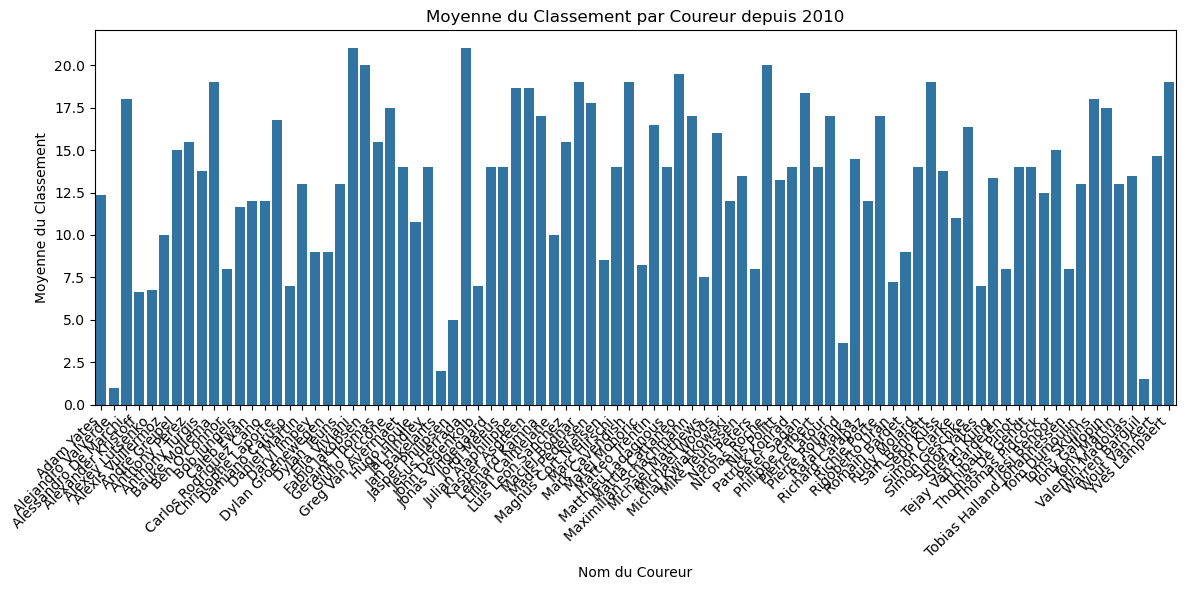

In [84]:
import matplotlib.pyplot as plt
import seaborn as sns

# Tracer un graphique en barres pour la moyenne du classement depuis 1980
plt.figure(figsize=(12, 6))
sns.barplot(x='nom', y='Moyenne_Classement', data=aggregated_data_since_2010)
plt.title('Moyenne du Classement par Coureur depuis 2010')
plt.xlabel('Nom du Coureur')
plt.ylabel('Moyenne du Classement')
plt.xticks(rotation=45, ha='right')  # Rotation des noms de coureurs pour une meilleure lisibilité
plt.tight_layout()

# Afficher le graphique
plt.show()


Graphiques des stats depuis 2010 : 

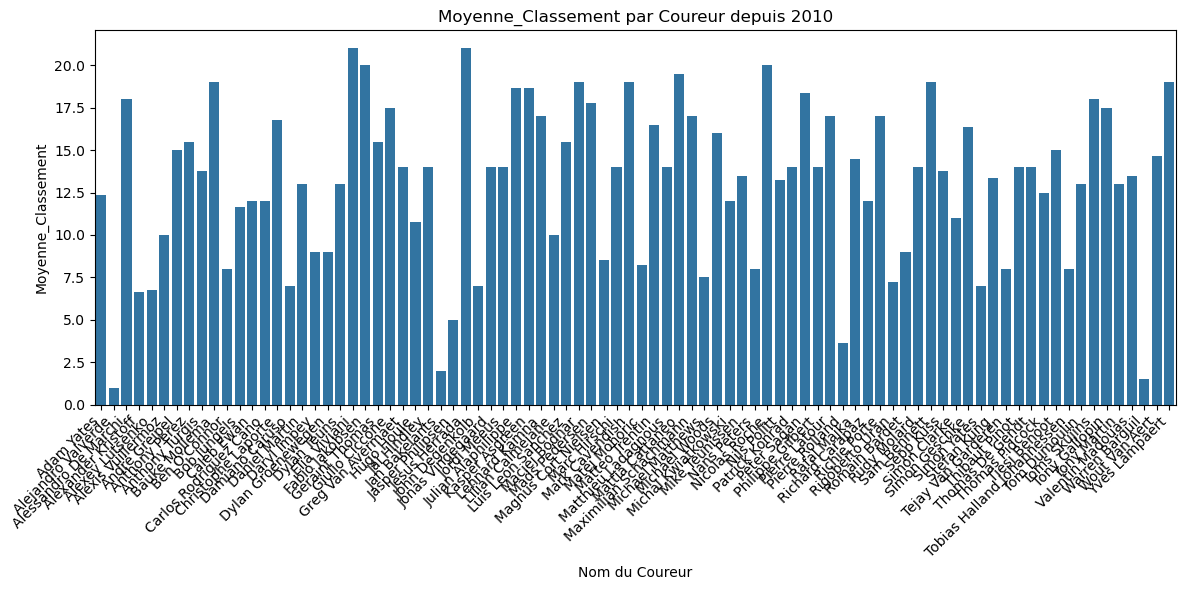

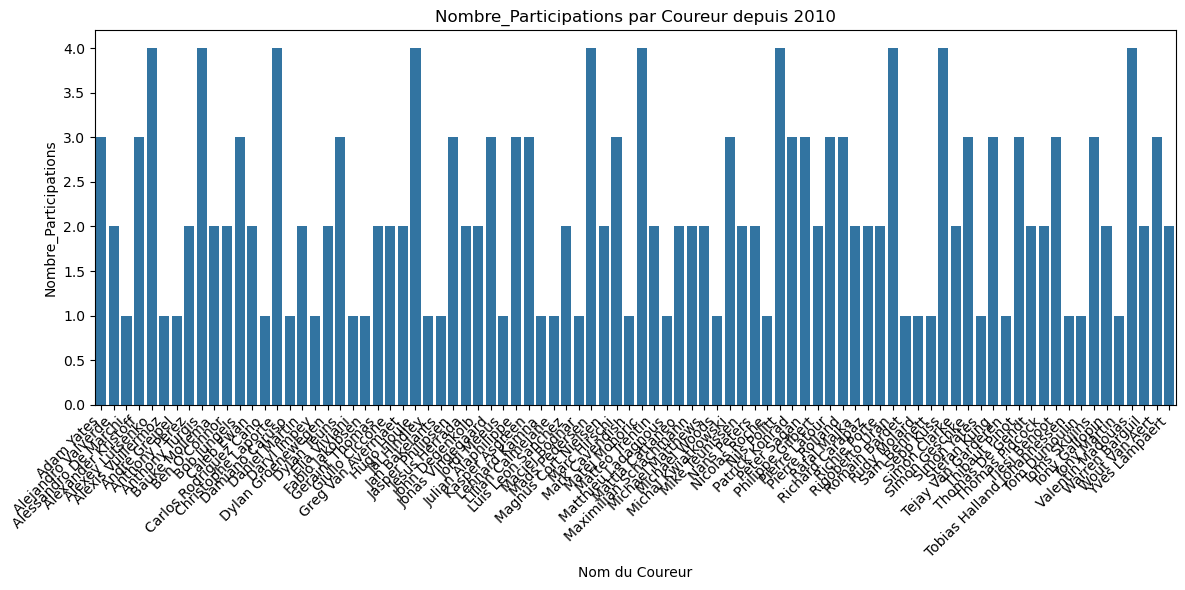

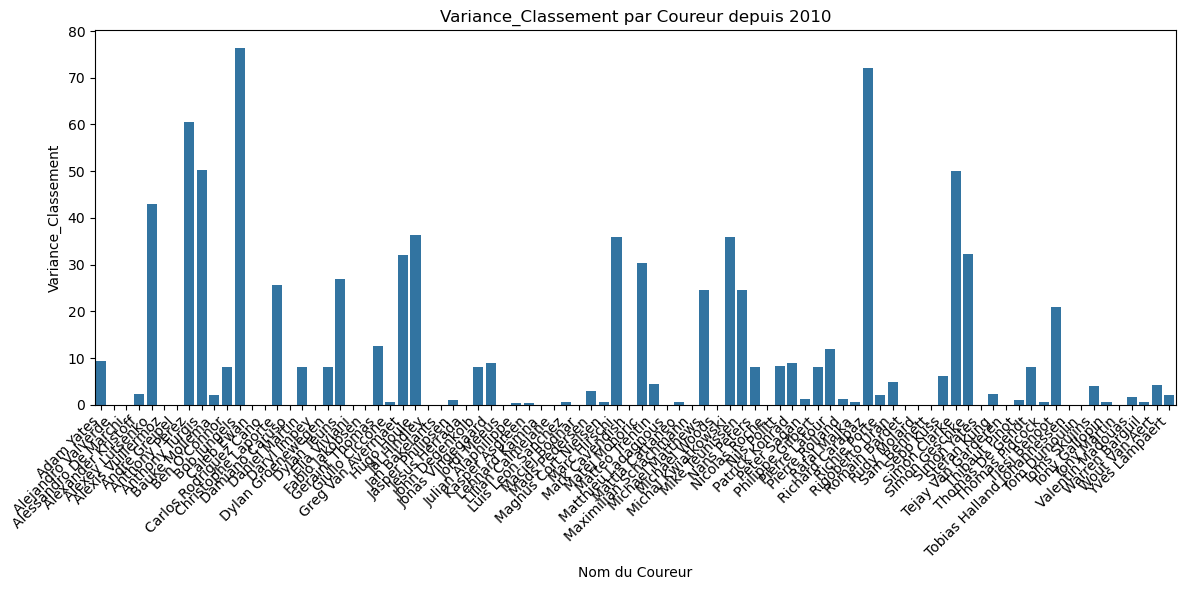

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

# Liste des statistiques à visualiser
statistiques = ['Moyenne_Classement', 'Nombre_Participations', 'Variance_Classement']

# Boucle pour créer un graphique pour chaque statistique
for stat in statistiques:
    plt.figure(figsize=(12, 6))
    sns.barplot(x='nom', y=stat, data=aggregated_data_since_2010)
    plt.title(f'{stat} par Coureur depuis 2010')
    plt.xlabel('Nom du Coureur')
    plt.ylabel(stat)
    plt.xticks(rotation=45, ha='right')  # Rotation des noms de coureurs pour une meilleure lisibilité
    plt.tight_layout()

# Afficher les graphiques
plt.show()


Base de données par coureur depuis 1980 pour voir les performances individuelles : 

In [87]:
# Supposez que votre DataFrame initial soit 'df'

# Filtrer les données pour les années à partir de 1980
df_since_1980 = df[df['Year'].dt.year >= 1980]

# Groupement par coureur
grouped_by_rider_since_1980 = df_since_1980.groupby('nom')

# Calcul des statistiques descriptives
average_rank_since_1980 = grouped_by_rider_since_1980['classement'].mean()
participation_count_since_1980 = grouped_by_rider_since_1980['Year'].count()
variance_performance_since_1980 = grouped_by_rider_since_1980['classement'].var()

# Création d'un nouveau DataFrame avec les données agrégées
aggregated_data_since_1980 = pd.DataFrame({
    'Moyenne_Classement': average_rank_since_1980,
    'Nombre_Participations': participation_count_since_1980,
    'Variance_Classement': variance_performance_since_1980
})

# Réinitialisation de l'index pour faire de 'nom' une colonne plutôt qu'un index
aggregated_data_since_1980.reset_index(inplace=True)


Effet du nombre de participation sur le classement moyen

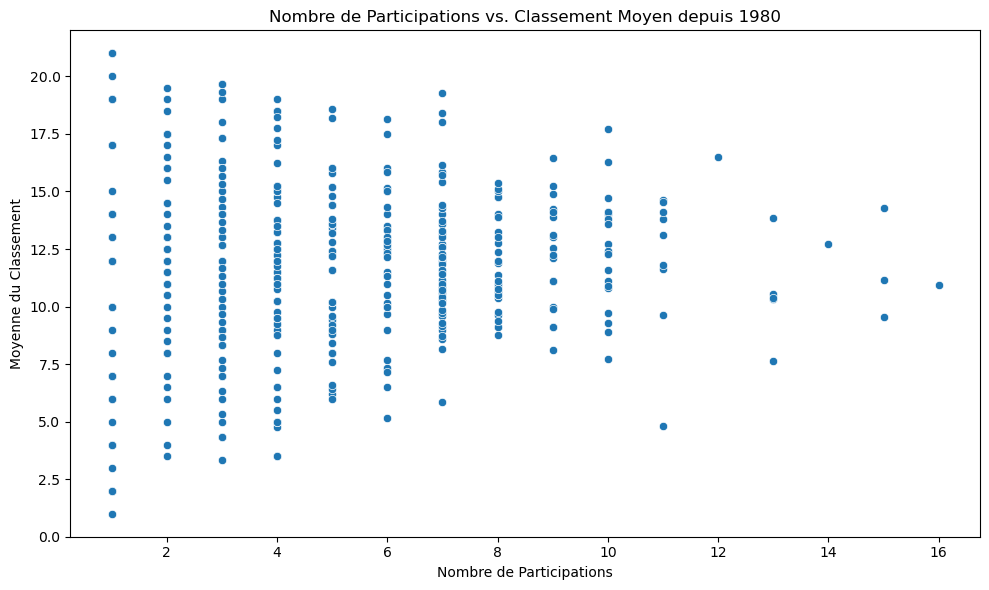

In [88]:
# Tracer un nuage de points pour le nombre de participations vs. le classement moyen
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Nombre_Participations', y='Moyenne_Classement', data=aggregated_data_since_1980)
plt.title('Nombre de Participations vs. Classement Moyen depuis 1980')
plt.xlabel('Nombre de Participations')
plt.ylabel('Moyenne du Classement')
plt.tight_layout()

# Afficher le nuage de points
plt.show()
